In [ ]:
# pip install openpyxl
# pip install cudaq

In [ ]:
import platform
import psutil
import subprocess
import cudaq
import numpy as np
import matplotlib
import sys
from datetime import datetime
import pandas as pd
import os

def get_system_info(computer_name):
    """Collect all system information"""
    
    data = {}
    
    # Computer name
    data['Computer Name'] = computer_name
    
    # Timestamp
    data['Timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # OS - COMPLETE
    data['OS'] = platform.system()
    data['OS Release'] = platform.release()
    data['OS Version'] = platform.version()
    data['Machine'] = platform.machine()
    
    # Linux Distribution - COMPLETE
    try:
        with open('/etc/os-release', 'r') as f:
            os_info = {}
            for line in f:
                if '=' in line:
                    key, value = line.strip().split('=', 1)
                    os_info[key] = value.strip('"')
            
            data['Distribution Name'] = os_info.get('NAME', 'N/A')
            data['Distribution Pretty Name'] = os_info.get('PRETTY_NAME', 'N/A')
            data['Distribution Version'] = os_info.get('VERSION', 'N/A')
            data['Distribution Version ID'] = os_info.get('VERSION_ID', 'N/A')
            data['Distribution ID'] = os_info.get('ID', 'N/A')
    except:
        data['Distribution Name'] = 'N/A'
        data['Distribution Pretty Name'] = 'N/A'
        data['Distribution Version'] = 'N/A'
        data['Distribution Version ID'] = 'N/A'
        data['Distribution ID'] = 'N/A'
    
    # CPU & RAM
    data['Physical CPUs'] = psutil.cpu_count(logical=False)
    data['Logical CPUs'] = psutil.cpu_count(logical=True)
    mem = psutil.virtual_memory()
    data['Total RAM (GB)'] = round(mem.total / (1024**3), 2)
    data['Available RAM (GB)'] = round(mem.available / (1024**3), 2)
    data['Used RAM (GB)'] = round(mem.used / (1024**3), 2)
    data['RAM Usage (%)'] = round(mem.percent, 1)
    
    # GPU - COMPLETE with VRAM
    try:
        # Get GPU names and VRAM total
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', 
                                '--format=csv,noheader'], 
                               capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            gpus = result.stdout.strip().split('\n')
            data['GPU Count'] = len(gpus)
            
            # Separate GPU names and VRAM
            gpu_names = []
            vram_total = []
            for gpu in gpus:
                parts = gpu.split(',')
                gpu_names.append(parts[0].strip())
                vram_total.append(parts[1].strip())
            
            data['GPU Names'] = ' | '.join(gpu_names)
            data['VRAM Total'] = ' | '.join(vram_total)  # e.g., "24564 MiB | 24564 MiB"
        else:
            data['GPU Count'] = 0
            data['GPU Names'] = 'No GPUs detected'
            data['VRAM Total'] = 'N/A'
    except:
        data['GPU Count'] = 0
        data['GPU Names'] = 'nvidia-smi not available'
        data['VRAM Total'] = 'N/A'
    
    # NVIDIA Driver & CUDA Version
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=driver_version', 
                                '--format=csv,noheader'], 
                               capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            data['NVIDIA Driver'] = result.stdout.strip().split('\n')[0]
        else:
            data['NVIDIA Driver'] = 'N/A'
            
        # Get CUDA version from nvidia-smi output
        result_smi = subprocess.run(['nvidia-smi'], 
                                   capture_output=True, text=True, timeout=5)
        if result_smi.returncode == 0:
            # Parse CUDA version from header
            for line in result_smi.stdout.split('\n'):
                if 'CUDA Version' in line:
                    cuda_version = line.split('CUDA Version:')[1].strip().split()[0]
                    data['CUDA Version'] = cuda_version
                    break
            else:
                data['CUDA Version'] = 'N/A'
        else:
            data['CUDA Version'] = 'N/A'
    except:
        data['NVIDIA Driver'] = 'N/A'
        data['CUDA Version'] = 'N/A'
    
    # GPU Temperature, Power, Memory Usage, Utilization
    try:
        result = subprocess.run(['nvidia-smi', 
                                '--query-gpu=temperature.gpu,power.draw,power.limit,memory.used,memory.total,utilization.gpu', 
                                '--format=csv,noheader'], 
                               capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            gpu_stats = result.stdout.strip().split('\n')
            temps = []
            powers = []
            vram_used = []
            gpu_utils = []
            for stat in gpu_stats:
                parts = stat.split(',')
                if len(parts) >= 6:
                    temps.append(parts[0].strip())
                    powers.append(f"{parts[1].strip()}/{parts[2].strip()}")
                    vram_used.append(parts[3].strip())
                    gpu_utils.append(parts[5].strip())
            
            data['GPU Temps (C)'] = ' | '.join(temps) if temps else 'N/A'
            data['GPU Power (W)'] = ' | '.join(powers) if powers else 'N/A'
            data['VRAM Used'] = ' | '.join(vram_used) if vram_used else 'N/A'  # e.g., "469 MiB | 18 MiB"
            data['GPU Utilization (%)'] = ' | '.join(gpu_utils) if gpu_utils else 'N/A'
        else:
            data['GPU Temps (C)'] = 'N/A'
            data['GPU Power (W)'] = 'N/A'
            data['VRAM Used'] = 'N/A'
            data['GPU Utilization (%)'] = 'N/A'
    except:
        data['GPU Temps (C)'] = 'N/A'
        data['GPU Power (W)'] = 'N/A'
        data['VRAM Used'] = 'N/A'
        data['GPU Utilization (%)'] = 'N/A'
    
    # Disk
    disk = psutil.disk_usage('/')
    data['Total Disk (GB)'] = round(disk.total / (1024**3), 2)
    data['Used Disk (GB)'] = round(disk.used / (1024**3), 2)
    data['Free Disk (GB)'] = round(disk.free / (1024**3), 2)
    data['Disk Usage (%)'] = round(disk.percent, 1)
    data['Free Disk (%)'] = round(100 - disk.percent, 1)
    
    # Software versions
    data['Python Version'] = platform.python_version()
    data['Python Executable'] = sys.executable
    data['CUDA-Q Version'] = str(cudaq.__version__ if hasattr(cudaq, '__version__') else 'Installed')
    data['NumPy Version'] = np.__version__
    data['Matplotlib Version'] = matplotlib.__version__
    
    return data

def save_to_excel(data, filename='system_history.xlsx'):
    """Save or append data to Excel file"""
    
    df_new = pd.DataFrame([data])
    
    if os.path.exists(filename):
        df_existing = pd.read_excel(filename)
        df_final = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_final = df_new
    
    df_final.to_excel(filename, index=False)
    print(f"✓ Data saved to {filename}")
    print(f"✓ Total entries: {len(df_final)}")


In [ ]:

# YOU RUN THIS:
computer_name = "iris" 

info = get_system_info(computer_name)

save_to_excel(info)

In [ ]:
# import pandas as pd
# import os
# from datetime import datetime

# def add_manual_entry(filename='./system_history.xlsx'):
#     """Add manual system info to Excel"""
    
#     # Create data dictionary with Esmeralda server values
#     data = {
#         'Computer Name': 'Esmeralda Server',  # <-- CHANGE THIS if needed
#         'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        
#         # OS Info
#         'OS': 'Linux',
#         'OS Release': '6.8.0-87-generic',
#         'OS Version': '#88~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Oct 14 14:03:14 UTC 2',
#         'Machine': 'x86_64',
        
#         # Distribution
#         'Distribution Name': 'Ubuntu',
#         'Distribution Pretty Name': 'Ubuntu 22.04.1 LTS',
#         'Distribution Version': '22.04.1 LTS (Jammy Jellyfish)',
#         'Distribution Version ID': '22.04',
#         'Distribution ID': 'ubuntu',
        
#         # CPU & RAM
#         'Physical CPUs': 12,
#         'Logical CPUs': 24,
#         'Total RAM (GB)': 31,
#         'Available RAM (GB)': 11,
#         'Used RAM (GB)': 19,
#         'RAM Usage (%)': round(19/31 * 100, 1),
        
#         # GPU Info
#         'GPU Count': 1,
#         'GPU Names': 'Quadro P620',
#         'VRAM Total': '2048 MiB',
        
#         # NVIDIA Driver & CUDA
#         'NVIDIA Driver': '535.274.02',
#         'CUDA Version': '12.2',
        
#         # GPU Stats (from nvidia-smi table)
#         'GPU Temps (C)': '42',
#         'GPU Power (W)': 'N/A',
#         'VRAM Used': '172 MiB',
#         'GPU Utilization (%)': '0',
        
#         # Disk
#         'Total Disk (GB)': 191,
#         'Used Disk (GB)': 46,
#         'Free Disk (GB)': 136,
#         'Disk Usage (%)': 26,
#         'Free Disk (%)': 74,
        
#         # Software
#         'Python Version': '3.10.12',
#         'Python Executable': '/mnt/deadmanschest/pxpalacios/v_ENV/clark_kent/bin/python',
#         'CUDA-Q Version': 'Not Available',
#         'NumPy Version': '2.1.0',
#         'Matplotlib Version': '3.10.3'
#     }
    
#     # Convert to DataFrame
#     df_new = pd.DataFrame([data])
    
#     # Append to Excel
#     if os.path.exists(filename):
#         df_existing = pd.read_excel(filename)
#         df_final = pd.concat([df_existing, df_new], ignore_index=True)
#     else:
#         df_final = df_new
    
#     df_final.to_excel(filename, index=False)
#     print(f"✓ Manual entry added to {filename}")
#     print(f"✓ Total entries: {len(df_final)}")
    
#     # Print what was added
#     print("\n" + "="*70)
#     print("Added entry:")
#     for key, value in data.items():
#         print(f"{key}: {value}")
#     print("="*70)

# # Run it
# add_manual_entry()

In [ ]:
# import pandas as pd
# import os
# from datetime import datetime

# def add_manual_entry(filename='system_history.xlsx'):
#     """Add manual system info to Excel"""
    
#     # Create data dictionary with your values
#     data = {
#         'Computer Name': 'CoreDevx',  # <-- CHANGE THIS
#         'Timestamp': '2025-11-22 20:51:48',  # From nvidia-smi output
        
#         # OS Info
#         'OS': 'Linux',
#         'OS Release': '6.8.0-87-generic',
#         'OS Version': '#88~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Oct 14 14:03:14 UTC 2',
#         'Machine': 'x86_64',
        
#         # Distribution
#         'Distribution Name': 'Ubuntu',
#         'Distribution Pretty Name': 'Ubuntu 22.04.5 LTS',
#         'Distribution Version': '22.04.5 LTS (Jammy Jellyfish)',
#         'Distribution Version ID': '22.04',
#         'Distribution ID': 'ubuntu',
        
#         # CPU & RAM
#         'Physical CPUs': 120,
#         'Logical CPUs': 120,
#         'Total RAM (GB)': 230.99,
#         'Available RAM (GB)': 225.48,
#         'Used RAM (GB)': round(230.99 - 225.48, 2),
#         'RAM Usage (%)': round((230.99 - 225.48) / 230.99 * 100, 1),
        
#         # GPU Info
#         'GPU Count': 2,
#         'GPU Names': 'NVIDIA GeForce RTX 4090 | NVIDIA GeForce RTX 4090',
#         'VRAM Total': '24564 MiB | 24564 MiB',
        
#         # NVIDIA Driver & CUDA
#         'NVIDIA Driver': '570.195.03',
#         'CUDA Version': '12.8',
        
#         # GPU Stats (from nvidia-smi table)
#         'GPU Temps (C)': '47 | 56',
#         'GPU Power (W)': '26W/450W | 17W/450W',
#         'VRAM Used': '469 MiB | 18 MiB',
#         'GPU Utilization (%)': '0 | 0',
        
#         # Disk
#         'Total Disk (GB)': 97.38,
#         'Used Disk (GB)': round(97.38 - 60.95, 2),
#         'Free Disk (GB)': 60.95,
#         'Disk Usage (%)': 34.0,
#         'Free Disk (%)': 66.0,
        
#         # Software
#         'Python Version': '3.12.6',
#         'Python Executable': '/opt/tljh/user/bin/python',
#         'CUDA-Q Version': 'CUDA-Q Version 0.11.0',
#         'NumPy Version': '2.3.2',
#         'Matplotlib Version': '3.10.3'
#     }
    
#     # Convert to DataFrame
#     df_new = pd.DataFrame([data])
    
#     # Append to Excel
#     if os.path.exists(filename):
#         df_existing = pd.read_excel(filename)
#         df_final = pd.concat([df_existing, df_new], ignore_index=True)
#     else:
#         df_final = df_new
    
#     df_final.to_excel(filename, index=False)
#     print(f"✓ Manual entry added to {filename}")
#     print(f"✓ Total entries: {len(df_final)}")
    
#     # Print what was added
#     print("\n" + "="*70)
#     print("Added entry:")
#     for key, value in data.items():
#         print(f"{key}: {value}")
#     print("="*70)

# # Run it
# add_manual_entry()

## Plots

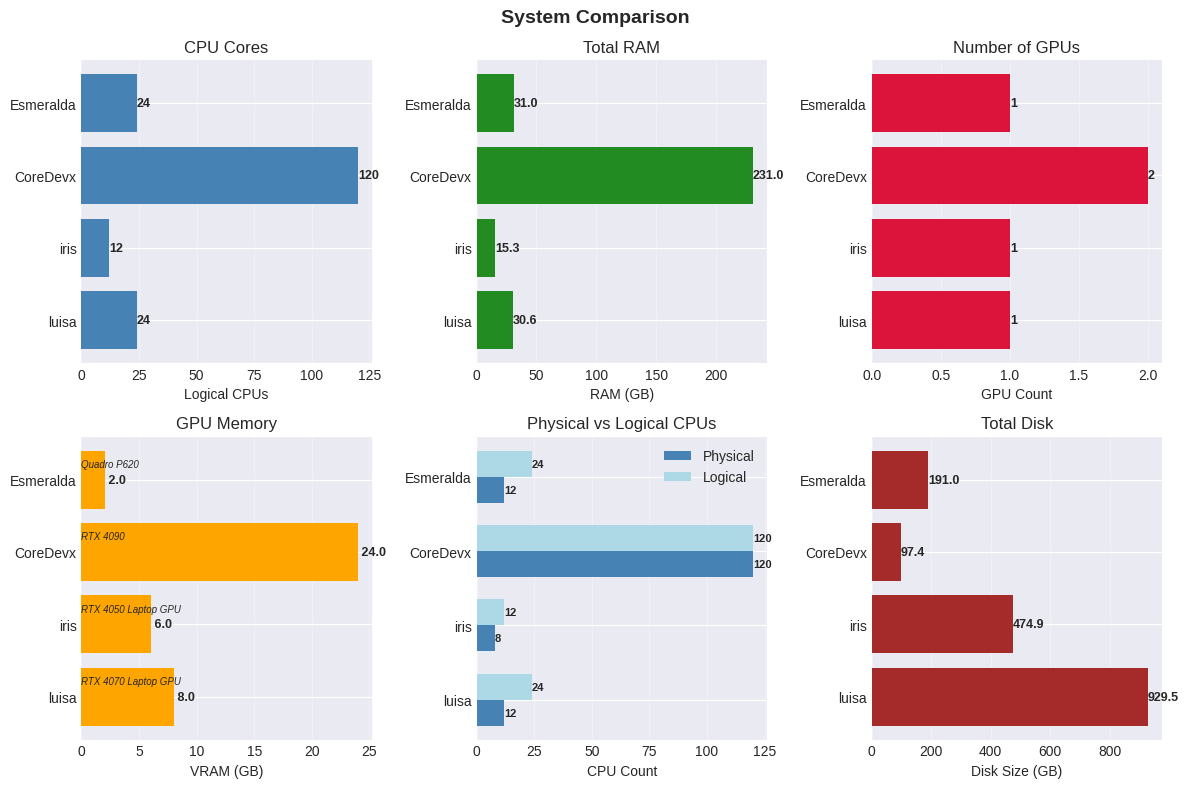

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the Excel file
df = pd.read_excel('system_history.xlsx')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('System Comparison', fontsize=14, fontweight='bold')

# 1. CPU Comparison
ax1 = axes[0, 0]
bars1 = ax1.barh(df['Computer Name'], df['Logical CPUs'], color='steelblue')
ax1.set_xlabel('Logical CPUs')
ax1.set_title('CPU Cores')
ax1.grid(axis='x', alpha=0.3)
for bar in bars1:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             ha='left', va='center', fontsize=9, fontweight='bold')

# 2. RAM Comparison
ax2 = axes[0, 1]
bars2 = ax2.barh(df['Computer Name'], df['Total RAM (GB)'], color='forestgreen')
ax2.set_xlabel('RAM (GB)')
ax2.set_title('Total RAM')
ax2.grid(axis='x', alpha=0.3)
for bar in bars2:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}', 
             ha='left', va='center', fontsize=9, fontweight='bold')

# 3. GPU Count
ax3 = axes[0, 2]
bars3 = ax3.barh(df['Computer Name'], df['GPU Count'], color='crimson')
ax3.set_xlabel('GPU Count')
ax3.set_title('Number of GPUs')
ax3.grid(axis='x', alpha=0.3)
for bar in bars3:
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             ha='left', va='center', fontsize=9, fontweight='bold')

# 4. VRAM Comparison with GPU names
ax4 = axes[1, 0]
vram_values_gb = []
gpu_names = []
for idx, row in df.iterrows():
    vram = row['VRAM Total']
    gpu_name = row['GPU Names']
    
    if isinstance(vram, str) and 'MiB' in vram:
        vram_mib = int(vram.split('MiB')[0].strip().split('|')[0])
        vram_values_gb.append(round(vram_mib / 1024, 1))
    else:
        vram_values_gb.append(0)
    
    # Simplify GPU name
    if isinstance(gpu_name, str):
        gpu_simple = gpu_name.split('|')[0].strip()
        gpu_simple = gpu_simple.replace('NVIDIA GeForce', '').replace('NVIDIA', '').strip()
        gpu_names.append(gpu_simple)
    else:
        gpu_names.append('N/A')

bars4 = ax4.barh(df['Computer Name'], vram_values_gb, color='orange')
ax4.set_xlabel('VRAM (GB)')
ax4.set_title('GPU Memory')
ax4.grid(axis='x', alpha=0.3)

for bar, val, gpu_name in zip(bars4, vram_values_gb, gpu_names):
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height()/2
    # Number on the right
    ax4.text(width, y_pos, f' {val:.1f}', 
             ha='left', va='center', fontsize=9, fontweight='bold')
    # GPU name above the bar
    ax4.text(0, y_pos + 0.15, gpu_name, 
             ha='left', va='bottom', fontsize=7, style='italic')

# 5. Physical vs Logical CPUs
ax5 = axes[1, 1]
x = np.arange(len(df))
bar_width = 0.35
bars_physical = ax5.barh(x - bar_width/2, df['Physical CPUs'], bar_width, label='Physical', color='steelblue')
bars_logical = ax5.barh(x + bar_width/2, df['Logical CPUs'], bar_width, label='Logical', color='lightblue')
ax5.set_yticks(x)
ax5.set_yticklabels(df['Computer Name'])
ax5.set_xlabel('CPU Count')
ax5.set_title('Physical vs Logical CPUs')
ax5.legend()
ax5.grid(axis='x', alpha=0.3)

# Add numbers to bars in graph 5
for bar in bars_physical:
    width = bar.get_width()
    ax5.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             ha='left', va='center', fontsize=8, fontweight='bold')
for bar in bars_logical:
    width = bar.get_width()
    ax5.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             ha='left', va='center', fontsize=8, fontweight='bold')

# 6. Total Disk Size
ax6 = axes[1, 2]
bars6 = ax6.barh(df['Computer Name'], df['Total Disk (GB)'], color='brown')
ax6.set_xlabel('Disk Size (GB)')
ax6.set_title('Total Disk')
ax6.grid(axis='x', alpha=0.3)
for bar in bars6:
    width = bar.get_width()
    ax6.text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}', 
             ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()